# Ford GoBike System Data Report

## Introduction

This document explores a dataset containing data from Ford GoBike, a Bay Area's bike sharing system.

You can check the definition of the variables included here: https://www.lyft.com/bikes/bay-wheels/system-data

Ford GoBike has data from mid 2017 to mid 2020. For the purpose of this analysis, I will focus on data for 2019, which includes data for 2506983 trips.

Some variables included in the 2019 dataset, bike_share_for_all_trip and rental_access_method, are have not been defined by Ford GoBike.

## Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import os
import glob
import requests
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from ipyleaflet import Map, Heatmap

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

## Gathering the data

The dataset provided by Ford GoBike is available in multiple data files. In this section the data is downloaded programmatically and saved into a CSV file.

In [2]:
# Create a list with the urls of the datasets to download
urls = []
for n in range(1,13):
    if n < 10:
        url = 'https://s3.amazonaws.com/baywheels-data/20190{}-fordgobike-tripdata.csv.zip'.format(n)
        urls.append(url)
    else:
        url = 'https://s3.amazonaws.com/baywheels-data/2019{}-fordgobike-tripdata.csv.zip'.format(n)
        urls.append(url)

In [3]:
# Some of the urls included the string baywheels, instead of fordgobike
for i in range(4, 12):
    urls[i] = urls[i].replace('fordgobike', 'baywheels')

In [4]:
# Download files, unzip the downloaded file and remove the ZIP file.
n = 0
for i in urls:
    csv_request = requests.get(i, allow_redirects=True)
    open(urls[n][40:], 'wb').write(csv_request.content)
    with zipfile.ZipFile(urls[n][40:], 'r') as zip_ref:
        zip_ref.extractall()
    os.remove(urls[n][40:])
    n += 1

In [5]:
# Assing all file names to the variable 'files'
extension = 'csv'
files = [i for i in glob.glob('*.{}'.format(extension))]

In [6]:
# Combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in files ])
# Export to csv
combined_csv.to_csv( "fordgobike.csv", index=False, encoding='utf-8')

In [7]:
# Create a data frame with all variable types as object
df = pd.read_csv('fordgobike.csv', dtype='object')

## Assessing the data

The main focus of this analysis will be on the following variables:

- duration_sec
- start_time
- user_type

I will also use latitude and longitude to create an interactive heat map at the end.

These variables have no null values.

Issues to solve in the cleaning process:
1. Convert duration_sec to integers, start_time to dates, and user_type to category.
2. Create variables for month, weekday and hour.
3. Rename start_station_latitude and start_station_longitude to 'lat' and 'lon'.
4. Remove irrelevant variables


In [8]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype 
---  ------                   --------------    ----- 
 0   duration_sec             2506983 non-null  object
 1   start_time               2506983 non-null  object
 2   end_time                 2506983 non-null  object
 3   start_station_id         2426249 non-null  object
 4   start_station_name       2426850 non-null  object
 5   start_station_latitude   2506983 non-null  object
 6   start_station_longitude  2506983 non-null  object
 7   end_station_id           2424081 non-null  object
 8   end_station_name         2424633 non-null  object
 9   end_station_latitude     2506983 non-null  object
 10  end_station_longitude    2506983 non-null  object
 11  bike_id                  2506983 non-null  object
 12  user_type                2506983 non-null  object
 13  bike_share_for_all_trip  2263724 non-null  object
 14  re

In [9]:
df.user_type.value_counts()

Subscriber    2021166
Customer       485817
Name: user_type, dtype: int64

## Clean

In [10]:
# Creata a copy of the orginal data frame
trips = df.copy()

**Define**: Convert duration_sec to integers, start_time to dates, and user_type to category.

**Code**

In [11]:
# Convert start_time to date format
trips.start_time = pd.to_datetime(trips.start_time)

In [12]:
# Convert duration_sec to integer format
trips.duration_sec = trips.duration_sec.astype('int')

In [13]:
# Convert user_type to category format
trips.user_type = trips.user_type.astype('category')

**Test**

In [14]:
trips[['start_time', 'duration_sec', 'user_type']].dtypes

start_time      datetime64[ns]
duration_sec             int64
user_type             category
dtype: object

**Define**: Create separate columns for start month, weekday and hour, and covert them to category format.

**Code**

In [15]:
# Create month column
trips['month'] = trips['start_time'].dt.strftime('%b')

In [16]:
# Create weekday column
trips['weekday'] = trips['start_time'].dt.strftime('%a')

In [17]:
# Create hour column
trips['hour'] = trips['start_time'].dt.strftime('%H')

In [18]:
# Convert month column to sorted category format
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
trips['month'] = pd.Categorical(trips['month'], categories=months, ordered=True)

In [19]:
# Convert weekday column to sorted category format
weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", 
          "Sun"]
trips['weekday'] = pd.Categorical(trips['weekday'], categories=weekdays, ordered=True)

In [20]:
# Convert hour column to sorted category format
hours = list(trips['hour'].value_counts().index.sort_values())
trips['hour'] = pd.Categorical(trips['hour'], categories=hours, ordered=True)

**Test**

In [21]:
trips.month.value_counts()

Jul    258102
Mar    256299
Oct    239895
Apr    239111
Sep    217986
Aug    210563
Jan    192082
Jun    191772
Nov    185496
Feb    183412
May    182163
Dec    150102
Name: month, dtype: int64

In [22]:
trips.weekday.value_counts()

Tue    427640
Thu    424474
Wed    414448
Fri    397284
Mon    396463
Sat    234370
Sun    212304
Name: weekday, dtype: int64

In [23]:
trips.hour.value_counts()

17    296831
08    278632
18    233587
09    215877
16    193253
19    143924
07    142099
15    124925
12    114164
13    111727
10    110032
14    108157
11    103194
20     92283
21     65063
06     53574
22     44412
23     26393
00     14686
05     13479
01      8788
02      5682
04      3442
03      2779
Name: hour, dtype: int64

In [24]:
trips[['month', 'weekday', 'hour']].info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype   
---  ------   --------------    -----   
 0   month    2506983 non-null  category
 1   weekday  2506983 non-null  category
 2   hour     2506983 non-null  category
dtypes: category(3)
memory usage: 7.2 MB


**Define**: Rename start_station_latitude and start_station_longitude to 'lat' and 'lon'.

**Code**

In [25]:
trips['lat'] = trips['start_station_latitude']
trips['lon'] = trips['start_station_longitude']

**Test**

In [26]:
trips[['lat', 'lon']].head()

lat                  lon
0  37.7763288173       -122.394438386
1      37.327581  -121.88455900000001
2  37.7873267661  -122.41327822209999
3     37.7633158         -122.4219039
4     37.7662185         -122.4310597

**Define**: Remove irrelevant variables

**Code**

In [27]:
trips = trips[['duration_sec', 'month', 'weekday', 'hour', 'user_type', 'lat', 'lon']]

**Test**

In [28]:
trips.head()

duration_sec month weekday hour   user_type            lat  \
0         60863   Sep     Mon   11    Customer  37.7763288173   
1         36019   Sep     Mon   16    Customer      37.327581   
2          5615   Sep     Mon   23    Customer  37.7873267661   
3          1482   Sep     Mon   23    Customer     37.7633158   
4          1272   Sep     Mon   23  Subscriber     37.7662185   

                   lon  
0       -122.394438386  
1  -121.88455900000001  
2  -122.41327822209999  
3         -122.4219039  
4         -122.4310597

## Exploratory

The following questions will work as a guideline to my exploration:

- **When are most trips taken in terms of time of day, day of the week, or month of the year?**


- **How long does the average trip take?**


- **Does the duration of a trip per month, weekday or hour depend on if a user is a subscriber or customer?**

### Univariate Exploration

Question 1: **When are most trips taken in terms of time of day, day of the week, or month of the year?**

Let's look at month first.

In [29]:
trips.month.value_counts()

Jul    258102
Mar    256299
Oct    239895
Apr    239111
Sep    217986
Aug    210563
Jan    192082
Jun    191772
Nov    185496
Feb    183412
May    182163
Dec    150102
Name: month, dtype: int64

The most popular month is July and the least is December.

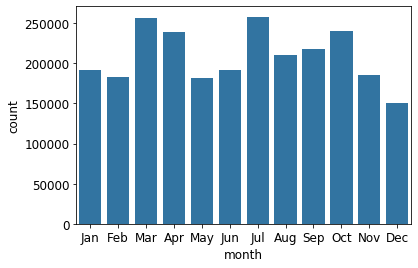

In [30]:
base_color = sns.color_palette()[0]
plt.rc('font', size=12)
sns.countplot(data = trips, x = 'month', color=base_color);

If we plot the relative frequencies:

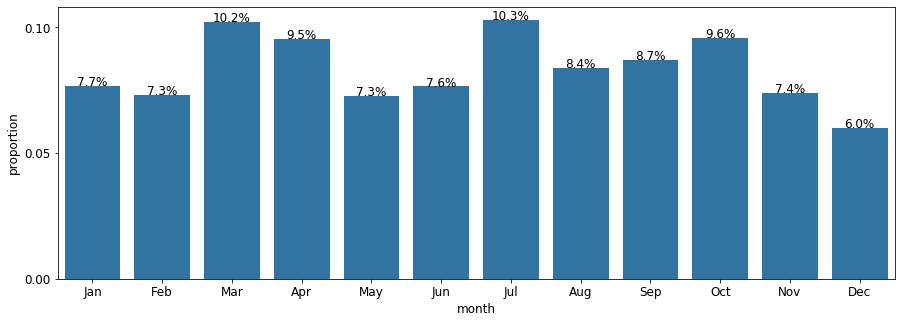

In [31]:
plt.figure(figsize=(15,5))
n_points = trips.shape[0]
cat_counts = trips['month'].value_counts()
max_count = cat_counts.max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
sns.countplot(data = trips, x = 'month', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
locs, labels = plt.xticks() # get the current tick locations and labels;

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'black')


We can see that July and March represent more than 20% of the trips in 2019. 

Now, let's take a look at weekday.

In [32]:
trips.weekday.value_counts()

Tue    427640
Thu    424474
Wed    414448
Fri    397284
Mon    396463
Sat    234370
Sun    212304
Name: weekday, dtype: int64

The most popular day is Tuesday and the least Sunday. The difference between week and weekend is quite salient if we visualize it:

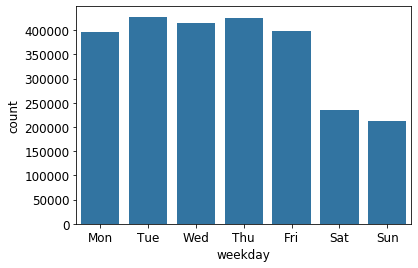

In [33]:
sns.countplot(data = trips, x = 'weekday', color=base_color);

If we look at relative frequencies:

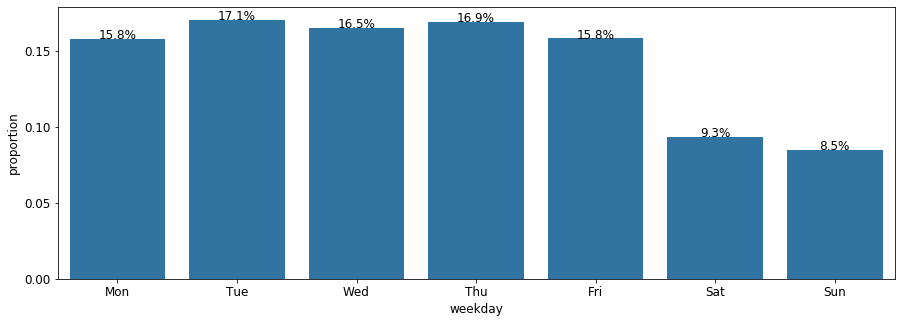

In [34]:
plt.figure(figsize=(15,5))
n_points = trips.shape[0]
cat_counts = trips['weekday'].value_counts()
max_count = cat_counts.max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
sns.countplot(data = trips, x = 'weekday', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
locs, labels = plt.xticks() # get the current tick locations and labels;

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'black')


Weekends represent less than 20% of the trips.

Finally, let's take a look at the hours in a day.

In [35]:
trips.hour.value_counts()

17    296831
08    278632
18    233587
09    215877
16    193253
19    143924
07    142099
15    124925
12    114164
13    111727
10    110032
14    108157
11    103194
20     92283
21     65063
06     53574
22     44412
23     26393
00     14686
05     13479
01      8788
02      5682
04      3442
03      2779
Name: hour, dtype: int64

17:00 is the most popular time and 03:00 is the least.

If we plot this, we can see two clear peaks between 07:00 and 10:00 and 16:00 and 19:00.

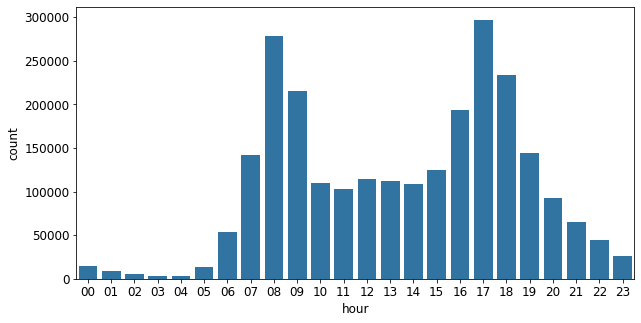

In [36]:
plt.figure(figsize=(10,5))
sns.countplot(data = trips, x = 'hour', color=base_color);

The relative frequencies are:

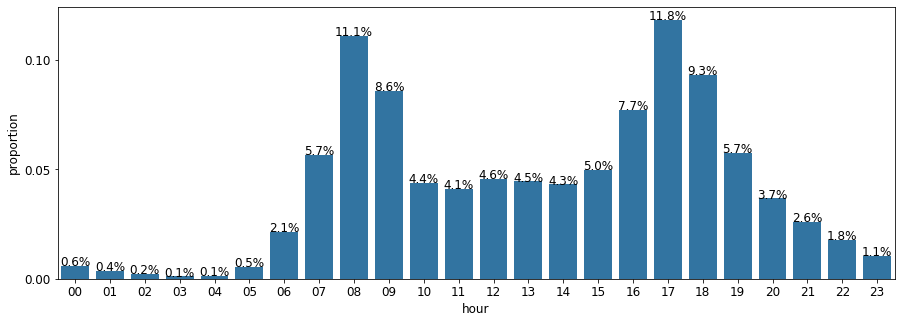

In [37]:
plt.figure(figsize=(15,5))
n_points = trips.shape[0]
cat_counts = trips['hour'].value_counts()
max_count = cat_counts.max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
sns.countplot(data = trips, x = 'hour', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
locs, labels = plt.xticks() # get the current tick locations and labels;

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'black')


54.2% of the trips take place during the peaks that we previously identified.

Question 2: **How long does the average trip take?**

To answer this, let's first take a look at the properties of the duration_sec variable.

In [38]:
trips.duration_sec.describe()

count    2.506983e+06
mean     8.076483e+02
std      1.974714e+03
min      6.000000e+01
25%      3.590000e+02
50%      5.710000e+02
75%      8.870000e+02
max      9.121100e+05
Name: duration_sec, dtype: float64

The maximum values is really high compared to the mean and so is the standard deviation.

Let's try to visualize this.

(0, 10000)

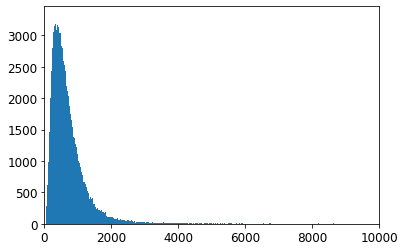

In [39]:
# after several attempts I have decided to zoom in on values from 0 to 1000.
bin_edges = np.arange(0, 10000 + 1, 1)
plt.hist(data = trips, x = 'duration_sec', bins = bin_edges)
plt.xlim(0, 10000)

I looks like most of the values are within the previous range. 

It is a very right skewed historgram with a very long tail.

I will do a logarithmic transformation, to have a better view of the main interval of duration_sec.

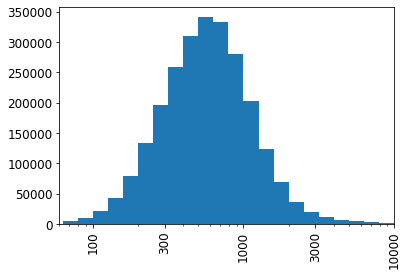

In [40]:
# log transformation and plotting between 60 and 10000)
bin_edges = 10 ** np.arange(0.8, np.log10(trips.duration_sec.max())+0.1, 0.1)
plt.hist(trips.duration_sec, bins = bin_edges)
plt.xscale('log')
tick_locs = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
plt.xticks(tick_locs, tick_locs, rotation = 90)
plt.xlim(60, 10000);

This creates a normally distributed histogram, with most values between 60 and 10000.

Despite the outliers, it seems like an average duration of 800 is not far away from reality. 

Looking at the histogram, I would say something around 500 would be more accurate.

In [41]:
# filter the data frame and get a descriptive summary
trips_f = trips[(trips['duration_sec'] > 60) & (trips['duration_sec'] < 1000)]
trips_f.describe()

duration_sec
count  2.016995e+06
mean   5.058520e+02
std    2.292119e+02
min    6.100000e+01
25%    3.200000e+02
50%    4.830000e+02
75%    6.780000e+02
max    9.990000e+02

### Bivariate Exploration

Here I will look at the average time for trips with a duration of more than 60 seconds and less that 1000 seconds, for each month, weekday and hour.

In [42]:
# filter the data frame
trips_f = trips[(trips['duration_sec'] > 60) & (trips['duration_sec'] < 1000)]

The duration in seconds per month:

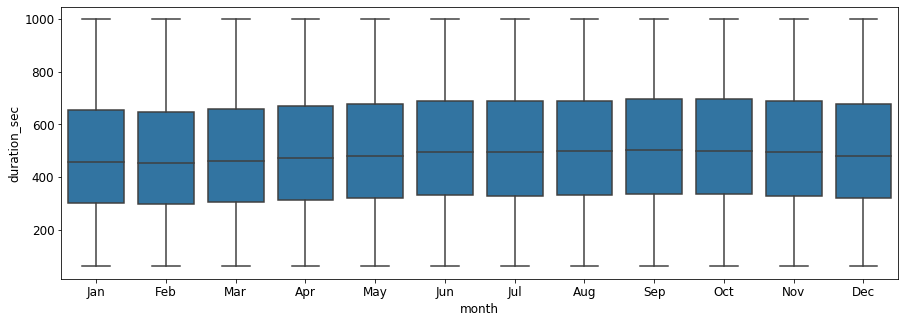

In [43]:
plt.figure(figsize=(15,5))
plt.rc('font', size=12)
sns.boxplot(data = trips_f, x = 'month', y = 'duration_sec', color = base_color);

It doesn't seem to vary much, with average values between 400 and 500.

Duration is seconds per weekday.

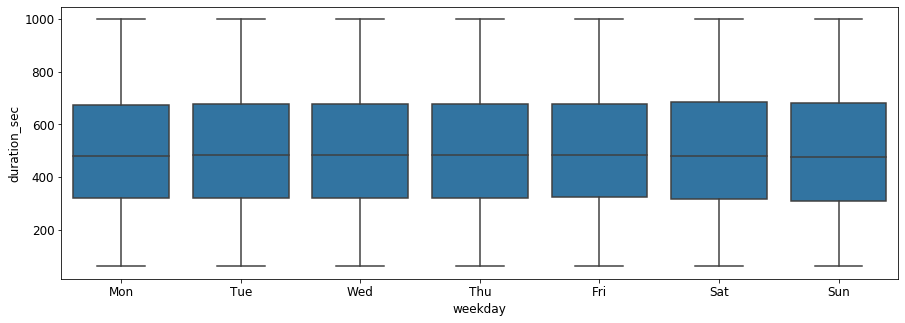

In [44]:
plt.figure(figsize=(15,5))
plt.rc('font', size=12)
sns.boxplot(data = trips_f, x = 'weekday', y = 'duration_sec', color = base_color);

Duration is very stable between weekdays. Even if we compare week and weekend.

Duration in seconds per hour of the day:

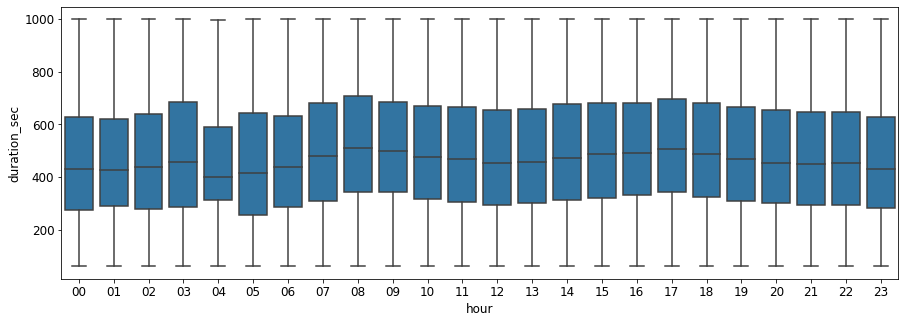

In [45]:
plt.figure(figsize=(15,5))
plt.rc('font', size=12)
sns.boxplot(data = trips_f, x = 'hour', y = 'duration_sec', color = base_color);

There is more variability here. It is possible to see similar peaks as we saw in the count of trips per hour of the day. However, there are some hight values between 02:00 and 04:00, which were not present in the count of trips per hour. This could mean that at that time there is a low frequency of trips, but duration is longer than at other times.

### Multivariate Exploration

Question 3: **Does the duration of a trip per month, weekday or hour depend on if a user is a subscriber or customer?**

To answer this question, I will look into, in each case two qualitative variables (month, weekday and hour on the one hand, and user_type on the other) and a quantitative varibale (duration_sec).

First I will do a bivariate comparison between duration and user_type:

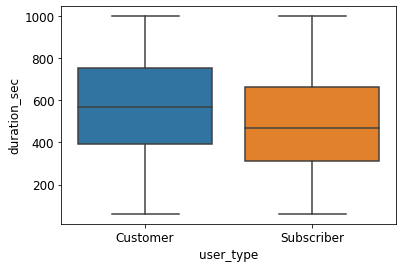

In [46]:
sns.boxplot(data = trips_f, x = 'user_type', y = 'duration_sec');

It looks like subscriber durations are lower than customers on average.

It would be interesting to have and idea of the distribution of the user_type variable:

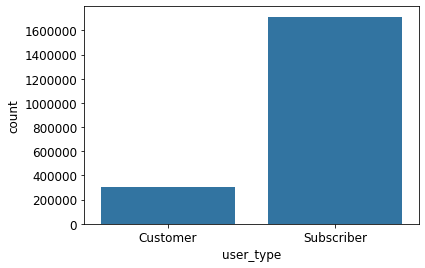

In [47]:
sns.countplot(data = trips_f, x = 'user_type', color=base_color);

In [48]:
trips_f.user_type.value_counts()

Subscriber    1713020
Customer       303975
Name: user_type, dtype: int64

From the graph and values, we can clearly see that the number of customers is not even 20% of the number of users.

This makes could be affecting the duration mean.

Let's now do a multivariate comparison of duration, user type and month:

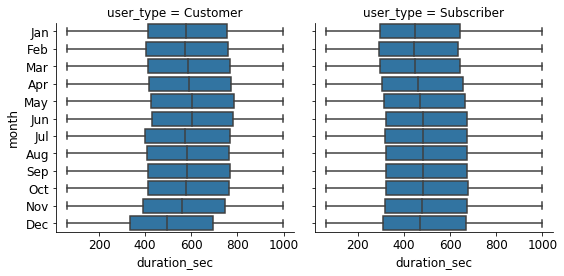

In [49]:
g = sns.FacetGrid(data = trips_f, col = 'user_type', height = 4)
g.map(sns.boxplot, 'duration_sec', 'month');

Again, it looks like subscriber durations are lower than customers on average by month.

Multivariate comparison of duration, user type and weekday:

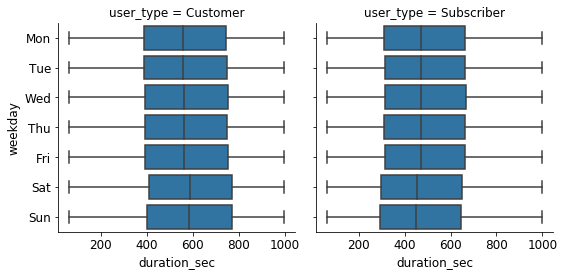

In [50]:
g = sns.FacetGrid(data = trips_f, col = 'user_type', height = 4)
g.map(sns.boxplot, 'duration_sec', 'weekday');

And again, it looks like subscriber durations are lower than customers on average by weekday.

Finally, multivariate comparison of duration, user type and hour:

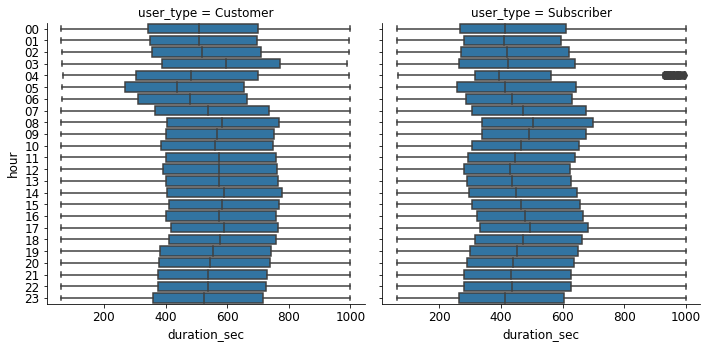

In [51]:
g = sns.FacetGrid(data = trips_f, col = 'user_type', height = 5)
g.map(sns.boxplot, 'duration_sec', 'hour');

Subscriber means are lower on average than Customer's. There seems to be some outliers in the Subscriber graph for 04:00.

### Heat Map

To complete this exploration, I will create an interactive heat map using the latitudes and longitudes from the dataset.

In [52]:
# create a new data frame with lat and lon as float
trips_loc = trips[['lat', 'lon']].astype(float)

In [53]:
# add variable intensity to use it in the creation of the heat map
trips_loc['intensity'] = 1

In [54]:
# create a tuple with the locations and intensity
locations = list(zip(trips_loc.lat, trips_loc.lon, trips_loc.intensity))

In [55]:
# create heat map
m = Map(center=[37.602120, -122.208263], zoom=9)

heat = Heatmap(locations=locations, radius=20, blur=20)
m.add_layer(heat)

# change some attributes of the heatmap
heat.radius = 30
heat.blur = 50
heat.max = 0.5
heat.gradient = {0.4: 'blue', 0.6: 'cyan', 0.7: 'lime', 0.8: 'yellow', 1.0: 'red'}
m

Map(center=[37.60212, -122.208263], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'â€¦

In [60]:
# the map cannot be seen in the HTML version of this document
# I am saving the map to an HTML document of its own
# if you are interested in checking it out, please be aware that it might take some time to load in your browser
# the file is around 200 MB, so if will not be included
# the best solution is to run this notebook
m.save('my_map.html', title='My Map')

With this heat map we can see where most of the trips start. It is possible to zoom in an out and the heat map layout changes showing more details into the areas where more and less trips start.

## Explanatory Summary

1. Question 1: **When are most trips taken in terms of time of day, day of the week, or month of the year?**

In terms of:
- Time of day: 17:00
- Day of the week: Tuesday
- Month of the year: July

**Other interesting insights**:

- Month:

The least popular month is December.

July and March represent more than 20% of the trips in 2019.

- Day of the week:

Weekend days have around half less trips than regular week days.

- Time of day:

3:00 is the least popular time.

There are two clear peaks between 07:00 and 10:00 and 16:00 and 19:00. This represent 54.2% of the trips in a day on average.


2. Question 2: **How long does the average trip take?**

The average trips takes around 500 seconds. This is after wrangling the data.

The orginal dataset shows an average of 800 seconds. However, this includes many, very high outliers.

**Other interesting insights**:

Most trips fall into the interval of 60 to 10000 seconds.

The largest amount of trips fall into the interval of 300 to 700 seconds.


3. Question 3: **Does the duration of a trip per month, weekday or hour depend on if a user is a subscriber or customer?**

Yes. The average duration for the subscriber is lower in all cases.

**Other interesting insights**:

Less than 20% of the users are customers.

- **Additional Insights**

The heat map shows that the trips' starting locations are in San Francisco, Oakland and San Jose.

## Resources

- Combine CSV files: https://www.freecodecamp.org/news/how-to-combine-multiple-csv-files-with-8-lines-of-code-265183e0854/
- Convert start_time to string months and weekdays: https://strftime.org/
- Heat map: https://ipyleaflet.readthedocs.io/en/latest/api_reference/heatmap.html

In [56]:
# create CSV files for the slides
trips.to_csv("trips.csv", index=False)
trips_loc.to_csv("trips_locations.csv", index=False)